# Predict Single Morphology Variable (Sersic n) Based on Multiple Star-formation Variables (M*, SFR and more)


In [29]:
#Loading needed modules and classes/functions 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

#3 Linear layers NN, 1 hidden 
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.linear1 = torch.nn.Linear(outputSize, outputSize)
        self.ReLU= torch.nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.linear1(x)
        x = self.ReLU(x)
        return x




# Importing Data from Schema Table

In [30]:


data=pd.read_csv('CompleteTable.csv')  #Importing All MaNGA Data from DPRall Schema

galaxy_list=np.loadtxt('Query Results',dtype=str) #Pulling Manga ID's of galaxies which satisfy log(M) > 9 and 0 < z < 0.1

galaxy_index=np.zeros(len(galaxy_list)) 
for i in range (len(galaxy_list)): #Getting the index of these galaxies in the schema table
    galaxy_index[i]=np.where(data.loc[:,'mangaid']==galaxy_list[i])[0][0]

galaxy_index=np.array(galaxy_index,dtype=int) #Ensuring we have array that can be used to index, force int 

galaxies=data.iloc[galaxy_index] #DF of galaxies which satisfies the condition, contains all relevant schema data 

#Creating the arrays of the independent variables were are interested in, and dependent variable n 

mass=galaxies.loc[:,'nsa_sersic_mass']
log_mass=np.log10(mass)

SFR=galaxies.loc[:,'sfr_tot']
log_SFR=np.log10(SFR)

ha_flux=galaxies.loc[:,'emline_gflux_tot_ha_6564']

n=galaxies.loc[:,'nsa_sersic_n']
n=np.array(n,dtype=np.float32)
n=torch.from_numpy(n).to('cuda:0').reshape(-1,1)






# Prep the input data to go into a DataLoader 

In [31]:
inputs=[log_SFR]

def data_preparer(inputs):  
    """
    Takes in a list in which each element is an input variable and then preps
    it accordingly to return it as one combined GPU pytorch tensor. 
    """
    for i in range (len(inputs)):
        inputs[i]=np.array(inputs[i],dtype=np.float32) #makes all inputs np arrays of np.float 32
    reshape=np.column_stack(inputs)
    out=torch.from_numpy(reshape).to('cuda:0')
    return(out)

inputs_tensor=data_preparer(inputs)

print(np.shape(inputs_tensor))
print(np.shape(n))

#Create Tensor Dataset 
train_ds=TensorDataset(inputs_tensor,n)

#Create Data Loader
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True)

print(train_ds[0])



torch.Size([3638, 1])
torch.Size([3638, 1])
(tensor([-1.2882], device='cuda:0'), tensor([6.], device='cuda:0'))


# The Model (N inputs, 1 output, CUDA Enabled)

In [32]:

inputDim=len(inputs)
outputDim=1 
learningRate=0.1

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=1000

epoch_array=np.zeros(epochs)
loss_array=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    for xb,yb in train_dl:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(xb)

        # get loss for the predicted output
        loss = criterion(outputs, yb)
        print(loss)
        # get gradients w.r.t to parameters, (backward pass)
        loss.backward()

        # update parameters
        optimizer.step()

        epoch_array[epoch]=epoch 
        loss_array[epoch]=loss.item()

        print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = model(inputs_tensor)
    print(predicted)



h 996, loss 3.2206029891967773
tensor(2.8289, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 2.8289177417755127
tensor(3.1679, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.167900800704956
tensor(3.1520, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.151951789855957
tensor(3.3146, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.3146417140960693
tensor(3.4926, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.4925649166107178
tensor(3.4721, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.4720749855041504
tensor(4.3745, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 4.374505996704102
tensor(3.7467, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.7466745376586914
tensor(3.1700, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.1700098514556885
tensor(3.5453, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 996, loss 3.5452661514282227
tensor(2.8028, device='cuda:0', 

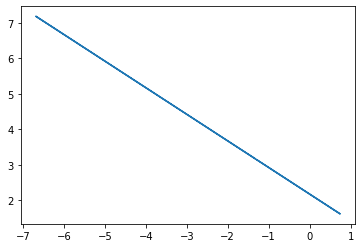

In [34]:
# plt.scatter(inputs_tensor.cpu().detach().numpy(),n.cpu().detach().numpy(),alpha=0.2)
plt.plot(inputs_tensor.cpu().detach().numpy(),predicted.cpu().detach().numpy())